In [2]:
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar_20, eval_u_Sonar_20_const
from SimpleSolver import SimpleSolver
from visualize_sonar import visualize_sonar_setup
from eval_g_Sonar import eval_g_Sonar
from simpleLeapFrog import *
import create_wave_animation as cwa
from IPython.display import display
from sonar_viz import plot_pressure_xz_at
import ipywidgets as widgets
import create_3d_wave_animation as cwa3d


Grid spacing: dx = 26.6667m, dz = 20.0000m
Sound speed: c = 1500.0 m/s
Max stable dt: 4.71e-03s

At f₀ = 20 Hz:
  Wavelength: λ = 75.00m
  Points per wavelength: 3
  Domain coverage: 106.7λ × 13.3λ


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

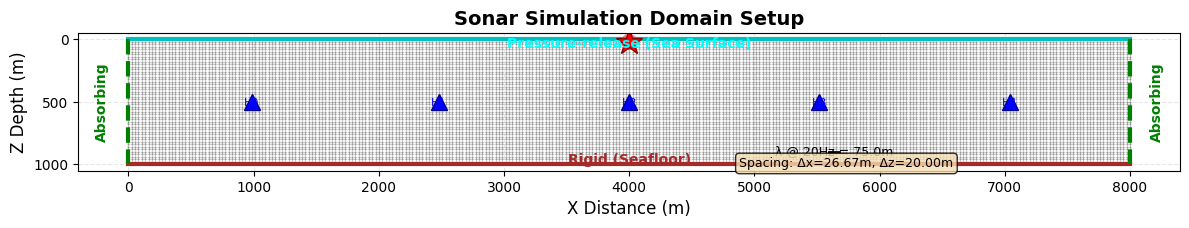

In [8]:
Lx, Lz = 8e3, 1e3       
Nx, Nz = 301, 51   
f0 = 20               
eval_u = eval_u_Sonar_20_const  

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True, BC=True)

t_stop += 1

# Scale u(t) by cell area so Bu remains grid-invariant with b=1/(dx*dz)
def eval_u_scaled(t):
    return (p['dx']*p['dz']) * eval_u(t)
eval_f = eval_f_Sonar

visualize = False
w = max_dt_FE * 0.1
num_iter = int(np.ceil((t_stop - t_start) / w)) 

print(f"\nGrid spacing: dx = {p['dx']:.4f}m, dz = {p['dz']:.4f}m")
print(f"Sound speed: c = {p['c']} m/s")
print(f"Max stable dt: {max_dt_FE:.2e}s")

# Wavelength check
wavelength = p['c'] / f0
print(f"\nAt f₀ = {f0} Hz:")
print(f"  Wavelength: λ = {wavelength:.2f}m")
print(f"  Points per wavelength: {wavelength/p['dx']:.0f}")
print(f"  Domain coverage: {Lx/wavelength:.1f}λ × {Lz/wavelength:.1f}λ")

visualize_sonar_setup(p, show_grid=True, show_boundary_labels=True)

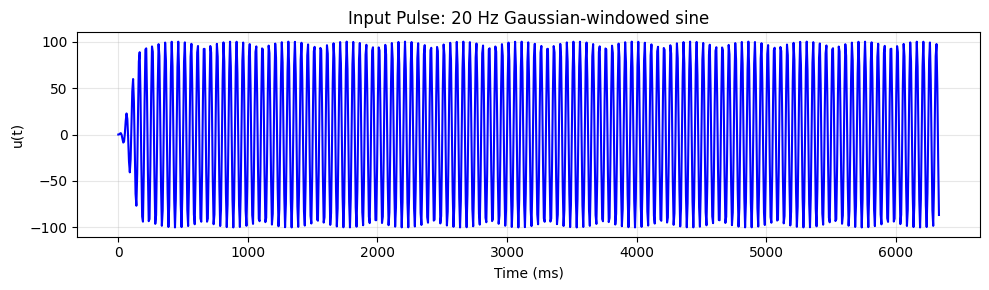

In [9]:
# Scale by cell area (same as PM1)
def eval_u_scaled(t):
    return (p['dx'] * p['dz']) * eval_u(t)

# Visualize pulse
t_test = np.linspace(0, t_stop, 1000)   
u_test = [eval_u(t) for t in t_test]

plt.figure(figsize=(10, 3))
plt.plot(t_test * 1000, u_test, 'b-', linewidth=1.5)
plt.xlabel('Time (ms)')
plt.ylabel('u(t)')
plt.title(f'Input Pulse: {f0} Hz Gaussian-windowed sine')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 13435 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 90.0%
  Progress: 100.0%
Leapfrog integration complete!
Processing hydrophone data...


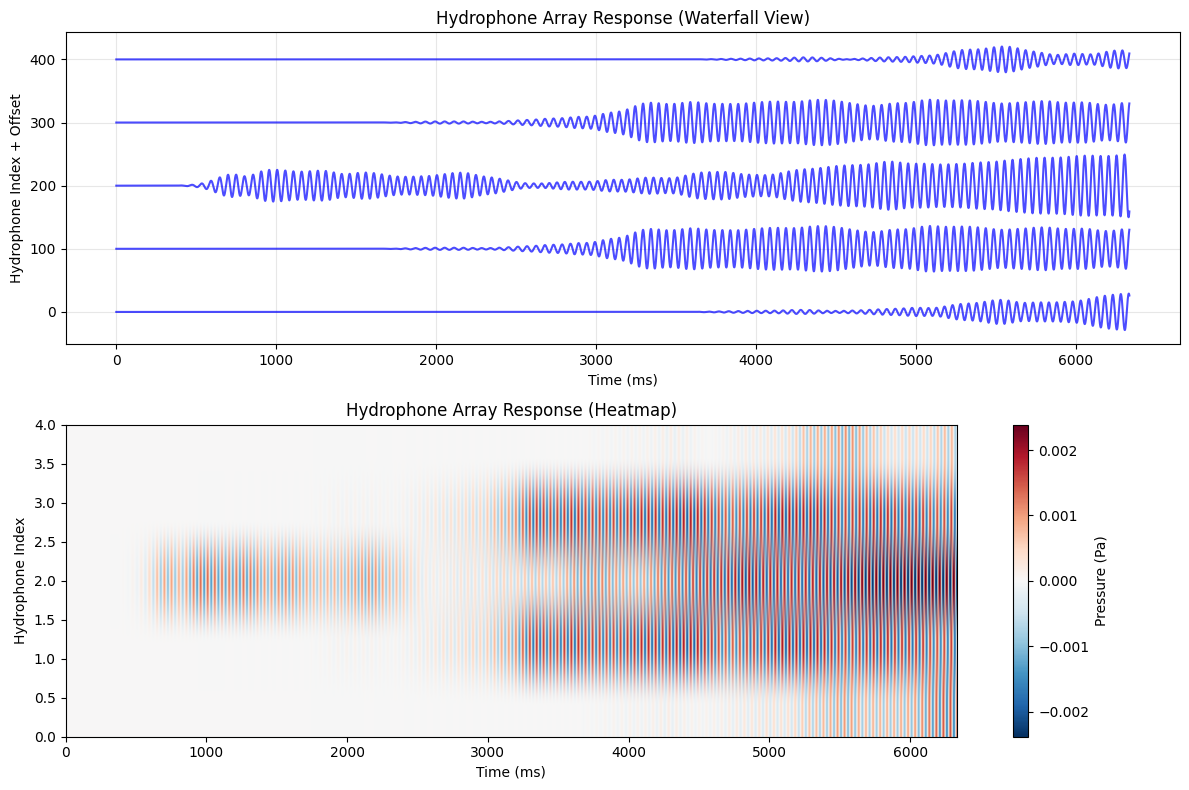

In [10]:
X, t = LeapfrogSolver(eval_f, x_start, p, eval_u_scaled, num_iter, dt=w, visualize=False)

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

adjust_view = 1e7 #1e9
# Auto-scale waveform display so traces are visible relative to offsets
amp = float(np.nanmax(np.abs(hydrophone_history)) + 1e-12)
adjust_view = 50.0 / amp
# Auto-scale waveform display so traces are visible relative to offsets
amp = float(np.nanmax(np.abs(hydrophone_history)) + 1e-12)
adjust_view = 50.0 / amp

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, adjust_view*hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
vmax = float(np.quantile(np.abs(hydrophone_history), 0.995) + 1e-12)
vmin = -vmax
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
im.set_clim(vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()


SOLVER STABILITY COMPARISON

1. Testing SimpleSolver (Forward Euler)...
started running a simple solver, please wait...

2. Testing LeapfrogSolver...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 10605 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 89.9%
  Progress: 99.9%
Leapfrog integration complete!

RESULTS:
Forward Euler - Final energy ratio: 2.95e+29
Leapfrog      - Final energy ratio: 1.24e+03
⚠️  Forward Euler is UNSTABLE (growing energy)


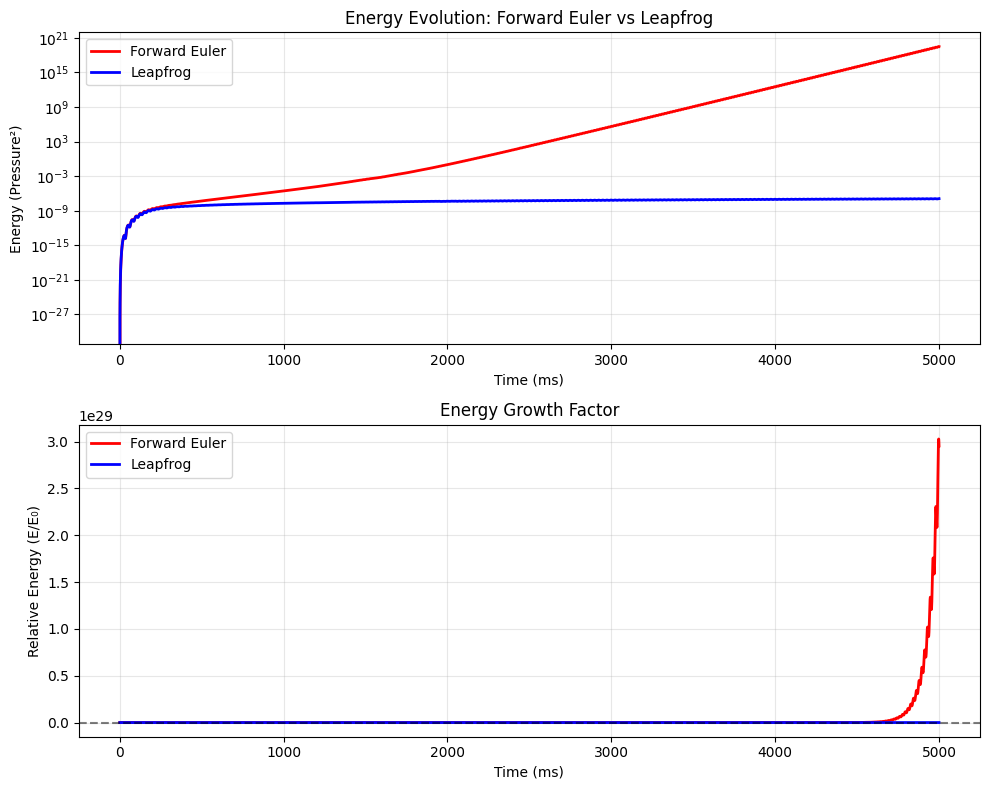

In [11]:
# Compare solvers
fig = test_solver_stability(p, eval_f, eval_u, x_start, max_dt_FE, duration=5)
plt.show()

In [ ]:
slider = widgets.IntSlider(value=int(len(np.asarray(t).reshape(-1)) - 1), min=0, max=int(X.shape[1] - 1), step=1, description='Index')
ui = widgets.HBox([slider])
out = widgets.interactive_output(lambda Index: plot_pressure_xz_at(p, X, t, index=Index), {'Index': slider})
display(ui, out)

Output()

In [ ]:
#cwa3d.create_3d_wave_animation(X, t, p, save_filename='wave_animation_3d.gif')

In [ ]:
surface_pressure = X[0::Nz, :]
print(f"Surface pressure range: {surface_pressure.min():.2e} to {surface_pressure.max():.2e}")

TEST BOUNDARIES

In [ ]:
# Taller domain to separate reflections in time
Lx, Lz = 2000, 500  # shorter in x to reduce lateral effects
Nx, Nz = 76, 51     # better vertical resolution

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True, BC=True)

# Override: source at mid-depth, center x
p['sonar_ix'] = Nx // 2
p['sonar_iz'] = Nz // 2

# Rebuild B matrix with new source location
N = Nx * Nz
def idx(i, j):
    return i * Nz + j

from scipy import sparse as sp
B_lil = sp.lil_matrix((2*N, 1), dtype=float)
source_idx = idx(p['sonar_ix'], p['sonar_iz'])
B_lil[N + source_idx, 0] = 1.0 / (p['dx'] * p['dz'])
p['B'] = B_lil.tocsr()

# Vertical array of hydrophones at source x-position
p['hydrophones'] = {
    'x_pos': p['sonar_ix'],
    'z_indices': list(range(1, Nz-1)),  # all depths except boundaries
    'n_phones': Nz - 2
}

def eval_u_pulse(t):
    sigma = 0.01   # 10ms width
    t0 = 0.05      # 50ms center
    A0 = 100
    
    if abs(t - t0) > 4 * sigma:
        return 0.0
    
    return A0 * np.exp(-(t - t0)**2 / (2 * sigma**2))

def eval_u_scaled(t):
    return (p['dx'] * p['dz']) * eval_u_pulse(t)

# Simulate long enough to see reflections
t_sim = 1  # seconds
w = max_dt_FE * 0.5
num_iter = int(np.ceil(t_sim / w))

print(f"Running {num_iter} iterations, dt={w*1000:.4f} ms")
X, t = LeapfrogSolver(eval_f, x_start, p, eval_u_scaled, num_iter, w, visualize=False)

In [ ]:
def extract_vertical_array(p, X, t):
    """Extract pressure time series along vertical array"""
    Nx, Nz = p['Nx'], p['Nz']
    x_pos = p['hydrophones']['x_pos']
    z_indices = p['hydrophones']['z_indices']
    
    n_times = X.shape[1]
    n_depths = len(z_indices)
    
    pressure = np.zeros((n_depths, n_times))
    
    for di, zi in enumerate(z_indices):
        flat_idx = x_pos * Nz + zi
        pressure[di, :] = X[flat_idx, :]
    
    depths = np.array(z_indices) * p['dz']
    return pressure, depths

pressure, depths = extract_vertical_array(p, X, t)

# Plot time-depth diagram
fig, ax = plt.subplots(figsize=(12, 6))

t_ms = np.array(t) * 1000
vmax = np.abs(pressure).max()

im = ax.imshow(pressure, aspect='auto', cmap='RdBu_r',
               extent=[t_ms[0], t_ms[-1], depths[-1], depths[0]],
               vmin=-vmax, vmax=vmax)

# Mark source depth
source_depth = p['sonar_iz'] * p['dz']
ax.axhline(source_depth, color='yellow', linestyle='--', linewidth=2, label='Source')

# Mark boundaries
ax.axhline(0, color='cyan', linestyle='-', linewidth=2, label='Surface (p=0)')
ax.axhline(p['Lz'], color='brown', linestyle='-', linewidth=2, label='Seafloor (dp/dn=0)')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Depth (m)')
ax.set_title('Vertical array: verify phase inversion at surface')
ax.legend(loc='upper right')
plt.colorbar(im, ax=ax, label='Pressure (Pa)')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

t_ms = np.array(t) * 1000
source_z_idx = p['sonar_iz'] - 1  # index in our array (offset by 1 since we skip z=0)

# Find indices for near-surface and near-bottom hydrophones
z_indices = p['hydrophones']['z_indices']
near_surface_idx = 1      # second from top
near_bottom_idx = -2      # second from bottom
mid_idx = len(z_indices) // 2

# Plot near-surface (should show phase inversion)
axes[0].plot(t_ms, pressure[near_surface_idx, :], 'b-', linewidth=1)
axes[0].set_ylabel('Pressure (Pa)')
axes[0].set_title(f'Near surface (z={depths[near_surface_idx]:.0f}m) - expect PHASE INVERSION on reflection')
axes[0].axhline(0, color='k', linestyle='-', alpha=0.3)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 300])

# Plot mid-depth (source location reference)
axes[1].plot(t_ms, pressure[mid_idx, :], 'g-', linewidth=1)
axes[1].set_ylabel('Pressure (Pa)')
axes[1].set_title(f'Mid-depth near source (z={depths[mid_idx]:.0f}m) - reference')
axes[1].axhline(0, color='k', linestyle='-', alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 300])

# Plot near-bottom (should show NO phase inversion)
axes[2].plot(t_ms, pressure[near_bottom_idx, :], 'r-', linewidth=1)
axes[2].set_ylabel('Pressure (Pa)')
axes[2].set_xlabel('Time (ms)')
axes[2].set_title(f'Near seafloor (z={depths[near_bottom_idx]:.0f}m) - expect NO phase inversion on reflection')
axes[2].axhline(0, color='k', linestyle='-', alpha=0.3)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 300])

plt.tight_layout()
plt.show()

In [ ]:
Nz = p['Nz']
Nx = p['Nx']
dz = p['dz']
c = p['c']
source_iz = p['sonar_iz']
source_ix = p['sonar_ix']

t_arr = np.array(t)
t_ms = t_arr * 1000

# Pulse timing - must match eval_u_pulse!
sigma = 0.01   # 10ms width
t0_pulse = 0.05  # 50ms center
t0_ms = t0_pulse * 1000

print(f"Pulse center time: {t0_ms:.1f}ms")
print(f"Pulse duration (~4 sigma): {4*sigma*1000:.1f}ms")

def get_waveform(iz):
    flat_idx = source_ix * Nz + iz
    return X[flat_idx, :]

# === SURFACE TEST ===
z_surf_test = 5
dist_source_to_phone = abs(source_iz - z_surf_test) * dz
dist_phone_to_surface = z_surf_test * dz

t_direct_surf = t0_ms + dist_source_to_phone / c * 1000
t_reflect_surf = t_direct_surf + 2 * dist_phone_to_surface / c * 1000

# === SEAFLOOR TEST ===
z_floor_test = Nz - 6
dist_source_to_phone_f = abs(z_floor_test - source_iz) * dz
dist_phone_to_floor = (Nz - 1 - z_floor_test) * dz

t_direct_floor = t0_ms + dist_source_to_phone_f / c * 1000
t_reflect_floor = t_direct_floor + 2 * dist_phone_to_floor / c * 1000

print(f"\nSource at z = {source_iz * dz:.0f}m")
print(f"\n--- SURFACE TEST (hydrophone at z={z_surf_test * dz:.0f}m) ---")
print(f"  Direct arrival: {t_direct_surf:.1f}ms")
print(f"  Reflection arrival: {t_reflect_surf:.1f}ms")
print(f"  Separation: {t_reflect_surf - t_direct_surf:.1f}ms")
print(f"  Pulse duration: {4*sigma*1000:.1f}ms")
print(f"  --> {'OVERLAP!' if (t_reflect_surf - t_direct_surf) < 4*sigma*1000 else 'Separated'}")

print(f"\n--- SEAFLOOR TEST (hydrophone at z={z_floor_test * dz:.0f}m) ---")
print(f"  Direct arrival: {t_direct_floor:.1f}ms")
print(f"  Reflection arrival: {t_reflect_floor:.1f}ms")
print(f"  Separation: {t_reflect_floor - t_direct_floor:.1f}ms")
print(f"  --> {'OVERLAP!' if (t_reflect_floor - t_direct_floor) < 4*sigma*1000 else 'Separated'}")

# Get waveforms
wf_surf = get_waveform(z_surf_test)
wf_floor = get_waveform(z_floor_test)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# --- TOP: Surface test ---
ax = axes[0]
ax.plot(t_ms, wf_surf, 'b-', linewidth=0.8)
ax.axvline(t_direct_surf, color='green', linestyle='--', linewidth=2, label=f'Direct @ {t_direct_surf:.0f}ms')
ax.axvline(t_reflect_surf, color='red', linestyle='--', linewidth=2, label=f'Reflection @ {t_reflect_surf:.0f}ms')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Pressure (Pa)')
ax.set_title(f'Surface test, expect phase inversion')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 300])

# --- BOTTOM: Seafloor test ---
ax = axes[1]
ax.plot(t_ms, wf_floor, 'b-', linewidth=0.8)
ax.axvline(t_direct_floor, color='green', linestyle='--', linewidth=2, label=f'Direct @ {t_direct_floor:.0f}ms')
ax.axvline(t_reflect_floor, color='orange', linestyle='--', linewidth=2, label=f'Reflection @ {t_reflect_floor:.0f}ms')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Pressure (Pa)')
ax.set_title(f'Seafloor test, expect no phase inversion')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 300])

plt.tight_layout()
plt.show()

# Surface BC check
surface_p = X[0::Nz, :]
print(f"\nSurface pressure (should be ~0): min={surface_p.min():.2e}, max={surface_p.max():.2e}")